# Lending Club - Predicting loan application rejections

_We are trying to forecast the number of loans rejected per month using Arima Time Series and LTSM models_

https://www.lendingclub.com/info/download-data.action

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns


from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

_Import the Lending Club rejection Application Datae from the Lending Club website_

In [2]:
from glob import glob
loan = sorted(glob('RejectStats_201*.csv'))

In [3]:
loan

['RejectStats_2017Q1.csv',
 'RejectStats_2017Q2.csv',
 'RejectStats_2017Q3.csv',
 'RejectStats_2017Q4.csv',
 'RejectStats_2018Q1.csv',
 'RejectStats_2018Q2.csv',
 'RejectStats_2018Q3.csv',
 'RejectStats_2018Q4.csv',
 'RejectStats_2019Q1.csv']

In [4]:
loans = pd.concat((pd.read_csv(file,
                               low_memory=False,
                               skiprows=[0]).iloc[:, [1]]
                   for file in loan),
                  ignore_index=True)

In [5]:
loans.tail()

,Application Date
19158650,2019-03-31
19158651,2019-03-31
19158652,2019-03-31
19158653,2019-03-31
19158654,2019-03-31


In [6]:
loans.shape

(19158655, 1)

In [7]:
loans.to_csv('RejectedLoans.csv')

_Only import the application data as the data_

In [8]:
df = pd.read_csv('RejectedLoans.csv', index_col=0)

/Users/charla/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
df = df.dropna()

In [10]:
df.head()

,Application Date
0,2017-01-01
1,2017-01-01
2,2017-01-01
3,2017-01-01
4,2017-01-01


In [11]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158655 entries, 0 to 19158654
Data columns (total 1 columns):
Application Date    object
dtypes: object(1)
memory usage: 292.3+ MB


((19158655, 1), None)

_The forecast will be computed on a weekly basis_

In [12]:
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas#45281439
# http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Rejected_Loan_Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Rejected_Loan_Count'].sum().reset_index().sort_values('Application_Date')

In [13]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 2 columns):
Application_Date       118 non-null datetime64[ns]
Rejected_Loan_Count    118 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


((118, 2), None)

In [14]:
df.head()

,Application_Date,Rejected_Loan_Count
0,2016-12-26,19659
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717


In [15]:
# I will drop the 2016 date.
df = df.loc[1:, :]

In [16]:
df.head()

,Application_Date,Rejected_Loan_Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [17]:
df.tail()

,Application_Date,Rejected_Loan_Count
113,2019-02-25,190241
114,2019-03-04,189141
115,2019-03-11,210487
116,2019-03-18,206549
117,2019-03-25,174618


In [18]:
print(df[df.duplicated('Application_Date')])

Empty DataFrame
Columns: [Application_Date, Rejected_Loan_Count]
Index: []


In [19]:
df.shape

(117, 2)

_Our dataset is not down to 117 rows, which is 117 weeks of loan data._

_We will create a date based index(pd.to datetime)._

In [20]:
df['Application_Date'] = pd.to_datetime(df['Application_Date'])

_What is the time range of the data_

In [21]:
print("Starts date {}".format(df['Application_Date'].min()))
print("Ends date {}".format(df['Application_Date'].max()))

Starts date 2017-01-02 00:00:00
Ends date 2019-03-25 00:00:00


In [22]:
dfIndex = df.set_index('Application_Date')
dfIndex.index

DatetimeIndex(['2017-01-02', '2017-01-09', '2017-01-16', '2017-01-23',
               '2017-01-30', '2017-02-06', '2017-02-13', '2017-02-20',
               '2017-02-27', '2017-03-06',
               ...
               '2019-01-21', '2019-01-28', '2019-02-04', '2019-02-11',
               '2019-02-18', '2019-02-25', '2019-03-04', '2019-03-11',
               '2019-03-18', '2019-03-25'],
              dtype='datetime64[ns]', name='Application_Date', length=117, freq=None)

In [23]:
dfIndex.tail()

,Rejected_Loan_Count
Application_Date,
2019-02-25,190241
2019-03-04,189141
2019-03-11,210487
2019-03-18,206549
2019-03-25,174618


Let's use pandas to create a date based index.

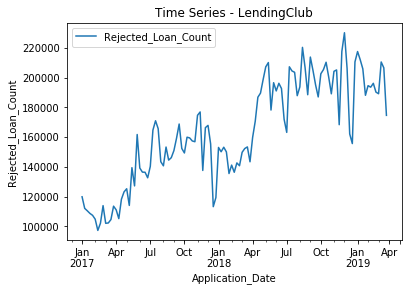

In [24]:
dfIndex.plot()
plt.title('Time Series - LendingClub')
plt.xlabel('Application_Date')
plt.ylabel('Rejected_Loan_Count')
plt.show()

_The data is not stationary, therefore we have to take the difference_

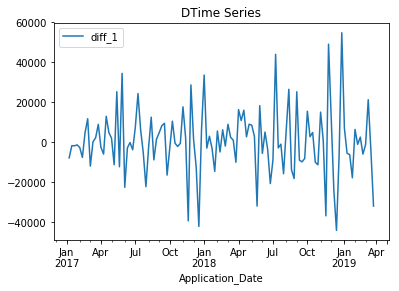

In [25]:
dfIndex['diff_1'] = dfIndex.Rejected_Loan_Count - \
    dfIndex.Rejected_Loan_Count.shift()
dfIndex.plot(y='diff_1')
plt.title('DTime Series')
plt.show()

In [26]:
dfIndex.head()

,Rejected_Loan_Count,diff_1
Application_Date,,
2017-01-02,119903,NaN
2017-01-09,112116,-7787.0
2017-01-16,110457,-1659.0
2017-01-23,108717,-1740.0
2017-01-30,107435,-1282.0


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
dfIndex = dfIndex.dropna()
dfIndex = dfIndex.drop('diff_1', axis=1)
decomposition = seasonal_decompose(dfIndex,
                                   model='additive')

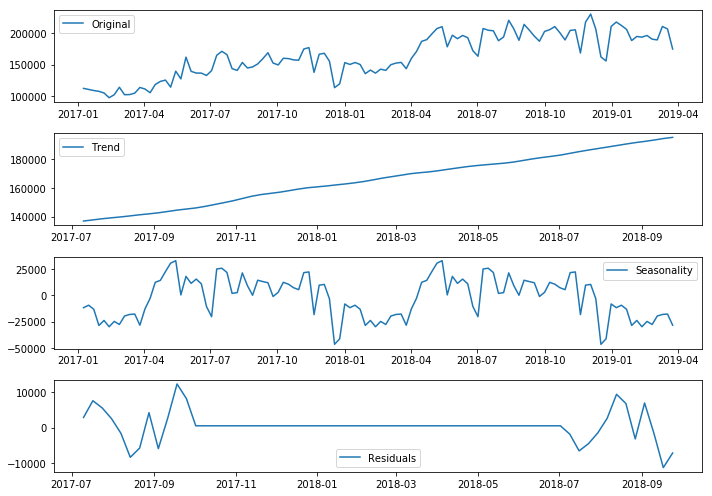

In [28]:
plt.figure(figsize=(10, 7))
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.subplot(411)
# plt.title('Original')
plt.plot(dfIndex.Rejected_Loan_Count, label='Original')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(412)
# plt.title('Trend')
plt.plot(trend, label='Trend')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(413)
# plt.title('Seasonality')
plt.plot(seasonal, label='Seasonality')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(414)
# plt.title('Residuals')
plt.plot(residuals, label='Residuals')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

_There is definetly a trend and seasonality in the data.  To handle the seasonality SARIMA will be used to forecast._


Here we can see that the trend and seasonality are separated out from data and we can model the residuals. 

In [29]:
dfIndex.tail(15)

,Rejected_Loan_Count
Application_Date,
2018-12-17,162124
2018-12-24,155657
2018-12-31,210521
2019-01-07,217498
2019-01-14,212040
2019-01-21,205848
2019-01-28,188093
2019-02-04,194570
2019-02-11,193545


----

### adfuller test

In [32]:
from statsmodels.tsa.stattools import adfuller

# raw data
acdf_test = adfuller(dfIndex['Rejected_Loan_Count'], autolag='AIC')
df_output = pd.Series(acdf_test[0:4], index=[
                      'Test Statistic',
                      'p-value',
                      '#lags used',
                      '#nobs used'])
print('raw data\n', df_output)
for k, v in acdf_test[4].items():
    print(k, v)

raw data
 Test Statistic     -1.653998
p-value             0.454956
#lags used          3.000000
#nobs used        112.000000
dtype: float64
1% -3.4901313156261384
5% -2.8877122815688776
10% -2.5807296460459184


_From this test, we see the time series is not stationary because the p-value is > 0.05_

### PACF for both the initial and differenced time series.

Text(0, 0.5, 'PACF')

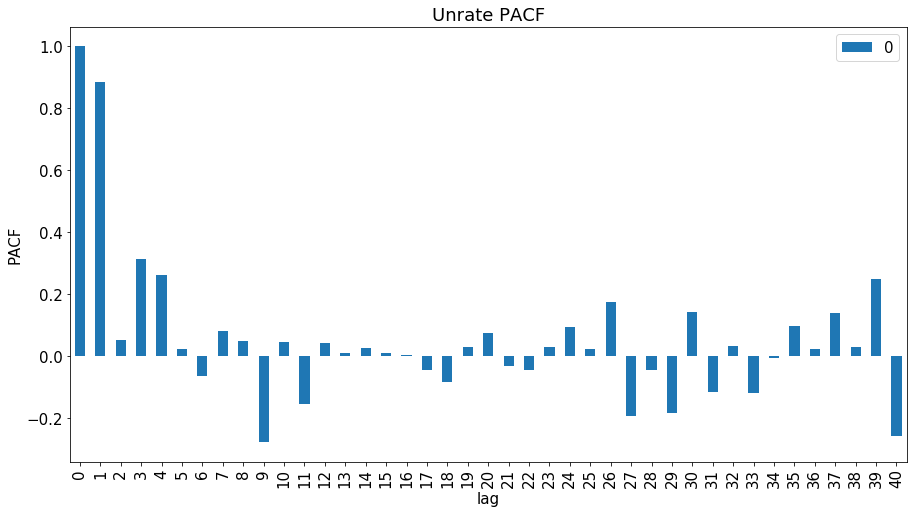

In [30]:
from statsmodels.tsa.stattools import pacf
# Plot Parameters
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams.update({'font.size': 15})
x_acf = pd.DataFrame(pacf(dfIndex.Rejected_Loan_Count))
x_acf.plot(kind='bar')
plt.title("Unrate PACF")
plt.xlabel('lag')
plt.ylabel('PACF')

Text(0, 0.5, 'diff PACF')

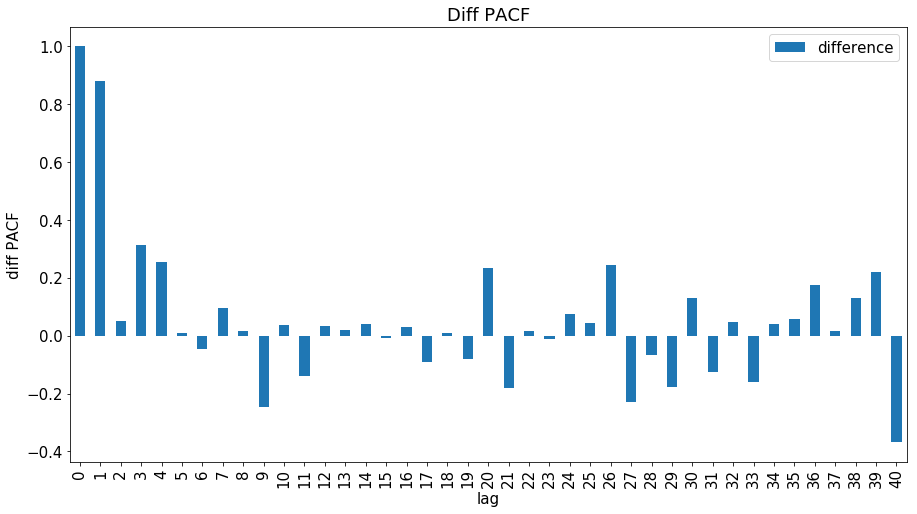

In [31]:
x_acf = pd.DataFrame(pacf(dfIndex.Rejected_Loan_Count.iloc[1:]))
x_acf.plot(kind='bar')
plt.title("Diff PACF")
plt.legend(['difference'])
plt.xlabel('lag')
plt.ylabel('diff PACF')

ACF-coefficients of correlation between a time series and lags of itself
PACF-partial correlation coefficients between the series and lags of itself

So both the original and the difference time series has 1 strong autocorrelation. This indicates that we should look into a p of 1 for our models.  

Looking at the ACF and PACF plots of the differenced series we see our first significant value at lag 1 for ACF and at the same lag 1 for the PACF which suggest to use p = 1 and q = 1. We also have a big value at lag lag 9 and 11 in the plots which suggests our season is S = (11) and if the lag is positive it suggests P = 0 and Q = 1. Since this is a differenced series for SARIMA we set d = 1, and since the seasonal pattern is not stable over time we set D = 0. Next we run SARIMA to see if these values are selected for the model on our training data.

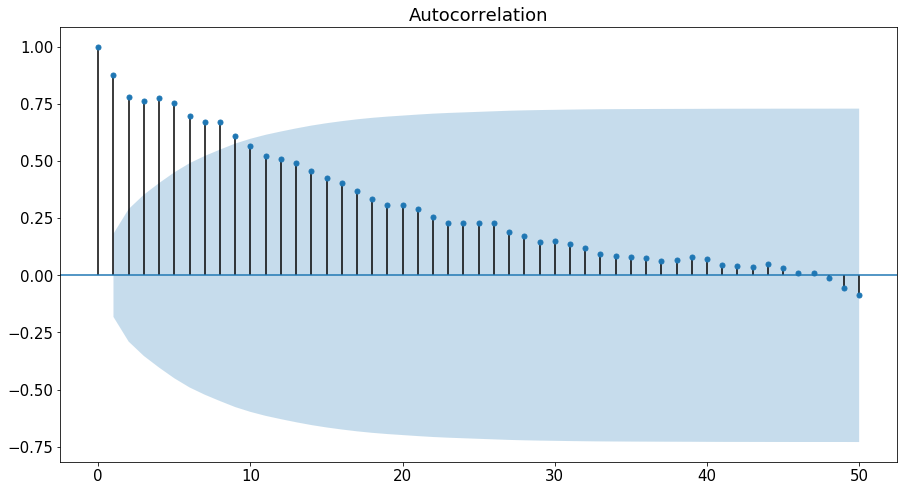

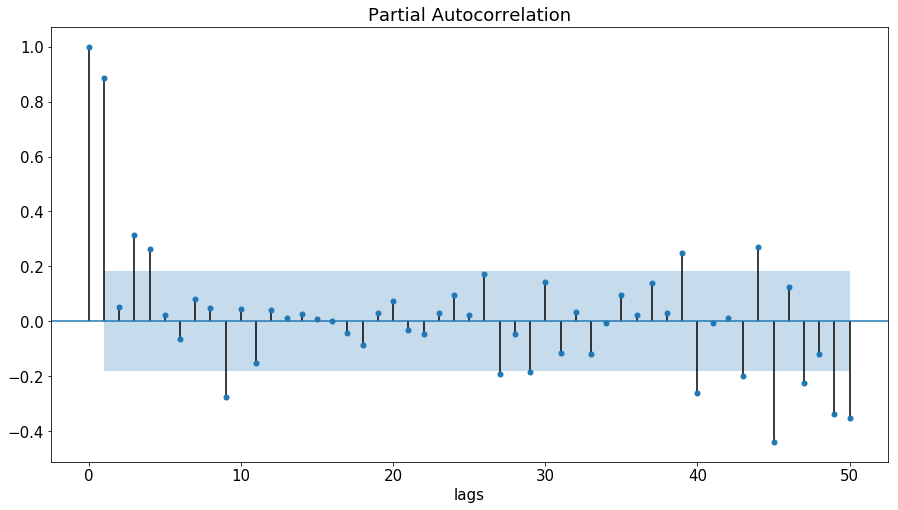

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(dfIndex['Rejected_Loan_Count'], lags=50)
plot_pacf(dfIndex['Rejected_Loan_Count'], lags=50)
plt.xlabel('lags')
plt.show()

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

* The ACF/PACF plots don't show a quick drop-off therefore it is not stationary.
* This data is non-stationary as a high number of previous observations are correlated with future values. The value in time t has some correlation from previous.
* Confidence intervals are the shaded area therefore any point outside is considered correlated.

* The Partial Autocorrelation asks the question, how many lags do you actually need, and that is 1 lag is needed

## Building models.

So our both time series has 1 strong autocorrelation. Let's build some ARIMA models to experiment and see how we do!

We're going to build a series of models to evaluate, each with slightly different parameters for the ARIMA. Note that the parameteres are passed in (p, d, q) order, corresponding to the AR, I, and MA portions respectively.

Recall how we interpret those attributes. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

_Now we need to find the best model, one which has the lowesr AIC._

In [499]:
# https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(dfIndex['Rejected_Loan_Count'],
                            start_p=0, start_q=0,
                            max_p=13, max_q=13, m=13,
                            start_P=0, start_Q=0,
                            seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            random_state=42,
                            n_fits=3,
                            stepwise=True)
stepwise_model.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 13); AIC=2337.103, BIC=2342.353, Fit time=0.473 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 13); AIC=2301.396, BIC=2311.896, Fit time=0.354 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 13); AIC=2287.446, BIC=2297.945, Fit time=0.657 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=2287.025, BIC=2300.150, Fit time=0.315 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 13); AIC=2294.004, BIC=2304.504, Fit time=0.264 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 13); AIC=2328.712, BIC=2336.587, Fit time=0.080 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 13); AIC=229

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1134.857
Date:                            Tue, 16 Jul 2019   AIC                           2281.713
Time:                                    16:18:21   BIC                           2297.463
Sample:                                         0   HQIC                          2288.091
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -315.9325    725.235     -0.436      0.663   -1737.367    1105.502
ma.L1         -0.3026      0.238     -1.272      0.204      -0.769       0.164
ma.L2         -0.2153      0.198     -1.086      0.278      -0.604       0.173
ar.S.L13      -0.2300      0.210     -1.096      0.273      -0.641       0.181
ma.S.L13      -0.6329      0.261     -2.428      0.015      -1.144      -0.122
sigma2      4.291e+08      0.001   7.23e+11      0.000    4.29e+08    4.29e+08
===================================================================================
Ljung-Box (Q):                       38.70   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.53   Prob(JB):                         0.65
Heteroskedasticity (H):               1.30   Skew:                             0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.64e+27. Standard errors may be unstable.
"""

In [35]:
dfIndex.shape

(116, 1)

### Forecast : Holdout will be 8 weeks of data

_Separate out the train and test for modeling.  I will use 8 weeks of data for the test data which leaves 108 weeks for training._

_So the Test dates would be 2019-02-04 through 2019-3-25._

In [36]:
train, test = dfIndex[:108], dfIndex[108:]
train.shape, test.shape

((108, 1), (8, 1))

In [37]:
test(20)

,Rejected_Loan_Count
Application_Date,
2019-02-04,194570
2019-02-11,193545
2019-02-18,196149
2019-02-25,190241
2019-03-04,189141
2019-03-11,210487
2019-03-18,206549
2019-03-25,174618


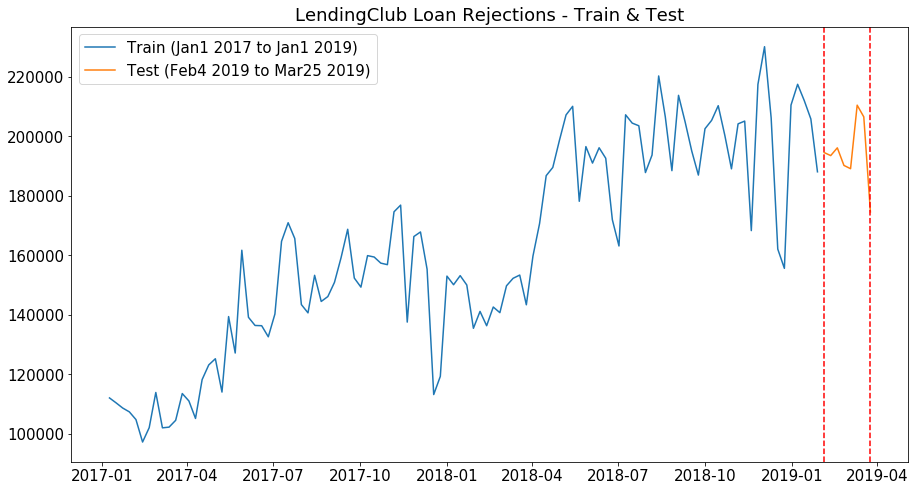

In [38]:
plt.plot(train, label='Train (Jan1 2017 to Jan1 2019)')
plt.plot(test, label='Test (Feb4 2019 to Mar25 2019)')
plt.title('LendingClub Loan Rejections - Train & Test')
plt.legend(loc='upper left')

xposition = ['2019-02-04', '2019-03-25']
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.show()

_The vertical markers represents the 8 weeks of test data, 2019-02-04 through 2019-3-25._

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Rejected_Loan_Count'], order=(0, 1, 2), seasonal_order=(
    1, 1, 1, 13), enforce_invertibility=True)
results = model.fit()
results.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Rejected_Loan_Count   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1044.654
Date:                            Sun, 14 Jul 2019   AIC                           2099.308
Time:                                    12:19:49   BIC                           2112.025
Sample:                                01-09-2017   HQIC                          2104.445
                                     - 01-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2829      0.204     -1.388      0.165      -0.682       0.117
ma.L2         -0.1902      0.179     -1.061      0.289      -0.541       0.161
ar.S.L13      -0.1997      0.212     -0.944      0.345      -0.614       0.215
ma.S.L13      -0.5822      0.255     -2.280      0.023      -1.083      -0.082
sigma2       3.93e+08   2.64e-10   1.49e+18      0.000    3.93e+08    3.93e+08
===================================================================================
Ljung-Box (Q):                       38.78   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.53   Prob(JB):                         0.43
Heteroskedasticity (H):               1.56   Skew:                             0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.24e+34. Standard errors may be unstable.
"""

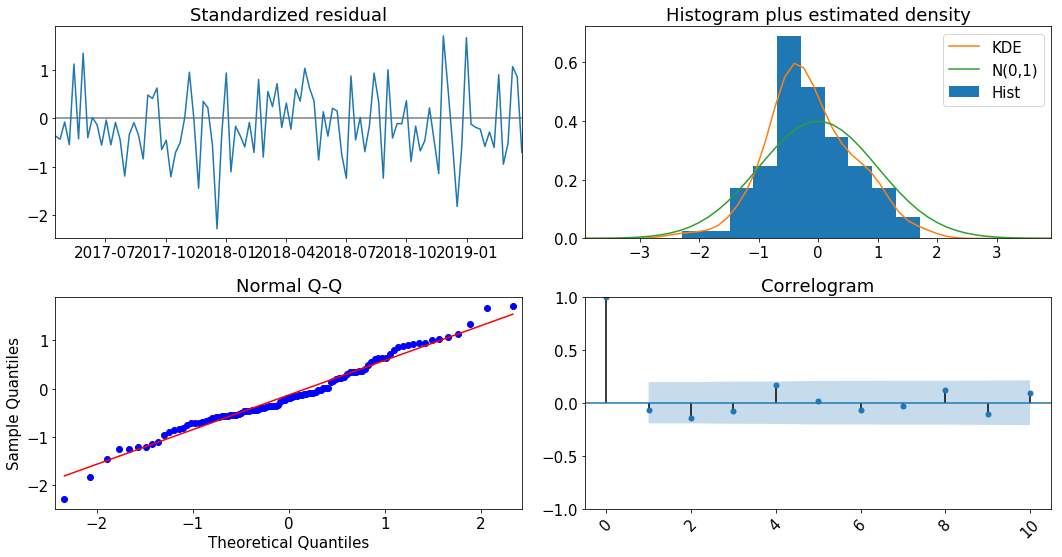

In [473]:
results.plot_diagnostics()
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

_The residuals look random and normaly distributed_

In [522]:
pred = pd.DataFrame(stepwise_model.predict(n_periods=8),
                    index=test.index)
pred.columns = ['Predicted_Num_Loans']

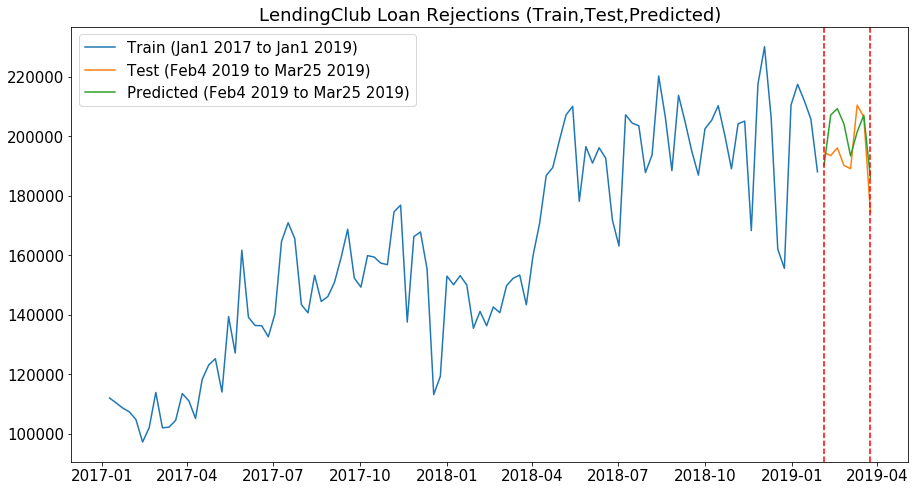

In [42]:
plt.title('LendingClub Loan Rejections (Train,Test,Predicted)')
plt.plot(train, label='Train (Jan1 2017 to Jan1 2019)')
plt.plot(test, label='Test (Feb4 2019 to Mar25 2019)')
plt.plot(pred, label='Predicted (Feb4 2019 to Mar25 2019)')
plt.legend(loc='upper left')
xposition = ['2019-02-04', '2019-03-25']
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.show()

In [43]:
test['Predicted_Count'] = pred
test['Error'] = test['Rejected_Loan_Count']-test['Predicted_Count']
test

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Rejected_Loan_Count,Predicted_Count,Error
Application_Date,,,
2019-02-04,194570,190282.514309,4287.485691
2019-02-11,193545,207165.140204,-13620.140204
2019-02-18,196149,209330.691465,-13181.691465
2019-02-25,190241,204185.997558,-13944.997558
2019-03-04,189141,193419.028761,-4278.028761
2019-03-11,210487,201513.062827,8973.937173
2019-03-18,206549,207129.721024,-580.721024
2019-03-25,174618,186142.098573,-11524.098573


In [44]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

actualMean = test['Rejected_Loan_Count'].sum() / test.shape[0]
print('Mean of Number of Loans: {:.2f}'.format(actualMean))

print('\nPredicted errors')
rmse = rmse(test['Predicted_Count'], test['Rejected_Loan_Count'])
mse = mean_squared_error(test['Predicted_Count'], test['Rejected_Loan_Count'])
print('Root Mean Square Error {:.2f}'.format(rmse))
print('Mean Squared Error {:.2f}'.format(mse))

percent_Mean_Error = (test['Rejected_Loan_Count'].sum() -
                      test['Predicted_Count'].sum())/(test.shape[0])


print('Percent Mean Error {:.2f}\n'.format(abs(percent_Mean_Error)))

print('The model is off by {:.2f}%.  \nThe with the mean number of loan = {:.2f}\nand the root mean square error of {:.2f}'
      .format(rmse/actualMean*100, actualMean, rmse))

Mean of Number of Loans: 194412.50

Predicted errors
Root Mean Square Error 10025.50
Mean Squared Error 100510732.85
Percent Mean Error 5483.53

The model is off by 5.16%.  
The with the mean number of loan = 194412.50
and the root mean square error of 10025.50


The model did a decent job of predicting the loan rejections per week.  If we look at the first week, it was off by 4287 loans out of 194,570.

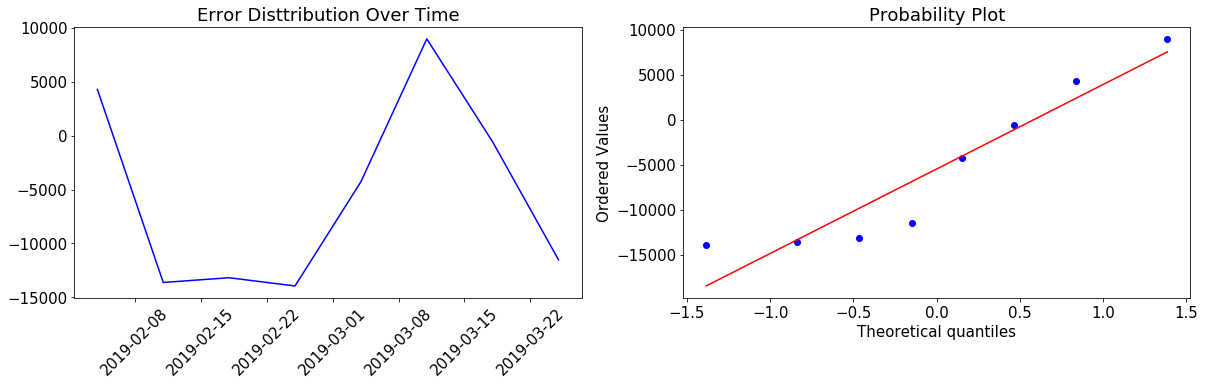

In [45]:
import pyramid as pm
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.xticks(rotation=45)
plt.plot(test.Error, color='blue')
plt.title('Error Disttribution Over Time')
plt.subplot(122)
scipy.stats.probplot(test.Error, plot=plt)

plt.show()

### Forecast for 12 weeks
_What does the forecast look like for 12 weeks?_

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dfIndex['Rejected_Loan_Count'], order=(0, 1, 2), seasonal_order=(
    0, 1, 1, 13), enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(dfIndex), len(dfIndex)+12,
                        typ='levels').rename('SARIMA 12 Week Forecast')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


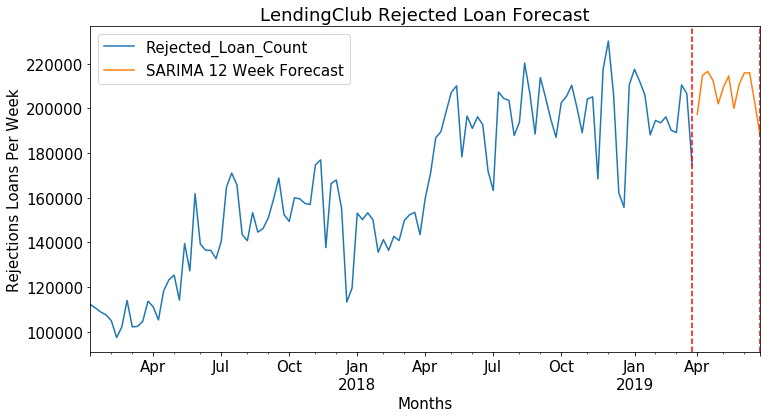

In [51]:
# Plot predictions against known values
import matplotlib.ticker as ticker
title = 'LendingClub Rejected Loan Forecast'
ylabel = 'Rejections Loans Per Week'
xlabel = 'Months'

ax = dfIndex['Rejected_Loan_Count'].plot(
    legend=True, figsize=(12, 6), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
xposition = ['2019-03-25', '2019-06-24']
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')

The 12 week forecast of rejected loans is seen in the plot above.  It looks to be on trend at about 200,000 loan applications rejected per week.  The forecast is for the weeks of March 26, 2019 to June 24, 2019. 

This forecast can be used to set weekly goals and expectations.  If you have a total number of loans weekly you can comebine the good and bad loan data to see what is the percentage of loans that are rejected and or approved.

--------------

# LSTM
We will use the same data for LSTM to predict 8 weeks of loans

LSTM is capable of learning long-term dependencies, remembering information for long periods of time. It consists of a chain of repeated moduls of neural networks.

The sigmod funcion helps to determine what to keep, if it is a 1 keep other wise get rid of it.

In [85]:
import pandas as pd

df = pd.read_csv('RejectedLoans.csv')
df = df.dropna()
df.shape

(19158655, 2)

In [86]:
df = df.drop('Unnamed: 0', axis=1)

In [87]:
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Rejected_Loan_Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Rejected_Loan_Count'].sum().reset_index().sort_values('Application_Date')

In [88]:
#df = df.dropna()
df = df.loc[1:, :]
df.shape

(117, 2)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 1 to 117
Data columns (total 2 columns):
Application_Date       117 non-null datetime64[ns]
Rejected_Loan_Count    117 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.7 KB


In [90]:
df.head()

,Application_Date,Rejected_Loan_Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [91]:
dataset = df.values

### Can LSTM predict 8 weeks of rejected loan applications?
_We will try to predict 8 weeks of loans.  There are 117 rows of data and each row represents a week of loans.  The train size is 109 weeks and the test siz is 8 weeks._

In [92]:
dataset_train, dataset_test = df[0:109], df[109:117]

In [93]:
training_set = dataset_train.iloc[:, 1:2].values
testing_set = dataset_test.iloc[:, 1:2].values

In [94]:
dataset_train.shape, dataset_test.shape, training_set.shape, testing_set.shape

((109, 2), (8, 2), (109, 1), (8, 1))

In [95]:
dataset_train.isna().sum()
dataset_test.isna().sum()

Application_Date       0
Rejected_Loan_Count    0
dtype: int64

In [96]:
dataset_test.head()

,Application_Date,Rejected_Loan_Count
110,2019-02-04,194570
111,2019-02-11,193545
112,2019-02-18,196149
113,2019-02-25,190241
114,2019-03-04,189141


Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1.

In [107]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [108]:
# create matrix
X_train = []
y_train = []
for i in range(8, 109):  # 8 time steps to figure out the next step
    X_train.append(training_set_scaled[i-8:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train,
                     (X_train.shape[0],
                      X_train.shape[1], 1))

In [109]:
X_test = []
y_test = []
for i in range(0, 8):
    X_test.append(testing_set_scaled[i-0:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [110]:
# matrix has 101 rows and 8 columns
# and trying to figure out the next step
# after the 8 time steps

# I am using the previous 8 time step(week) to predict the 9th time step(week)
X_train.shape, X_test.shape

((101, 8, 1), (8, 0, 1))

Again, I am predicting the next 2 months (8 weeks) of loan rejections (101,8,1).  This tells me I have 101 weeks of data and I am using the previous 8 weeks of data to predict the next week.

In [479]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from keras.optimizers import SGD

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
import time

In [480]:
# to use tensorflow alpha install this
#!pip install --upgrade pip

In [500]:
#Set up tensorboard
#!pip3 install -U pip --user tensorflow
NAME = "lendingClub8weeks{}".format(int(time.time()))
!rm -rf ./Users/charla/*jupyter_notebook_projects/logs/ #clear out logs
sess = tf.Session()
f = tf.summary.FileWriter(
    '/Users/charla/*jupyter_notebook_projects/logs/', sess.graph)

In [501]:
tf.keras.layers.LSTM
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

### LSTM setup
_To prevent overfitting (wrong connections) I will randomly disable some neurons(0.7). There are 3 layers with 1 output. It uses the Adam learning rate and 900 epoch(back and forths that are done)._

In [502]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=100,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1))


lstm_model.compile(optimizer='adam',
                   loss='mean_squared_error')

history = lstm_model.fit(X_train,
                         y_train,
                         epochs=900,
                         batch_size=1,
                         callbacks=[tensorboard])

Epoch 1/900
101/101 [==============================] - 9s 90ms/step - loss: 0.0634
Epoch 2/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0285
Epoch 3/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0277
Epoch 4/900
101/101 [==============================] - 4s 40ms/step - loss: 0.0227
Epoch 5/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0238
Epoch 6/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0211
Epoch 7/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0223
Epoch 8/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0228
Epoch 9/900
101/101 [==============================] - 4s 41ms/step - loss: 0.0340
Epoch 10/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0252
Epoch 11/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0300
Epoch 12/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0227
E

101/101 [==============================] - 4s 39ms/step - loss: 0.0122
Epoch 99/900
101/101 [==============================] - 4s 40ms/step - loss: 0.0142
Epoch 100/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0136
Epoch 101/900
101/101 [==============================] - 4s 40ms/step - loss: 0.0133
Epoch 102/900
101/101 [==============================] - 4s 39ms/step - loss: 0.0128
Epoch 103/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0146
Epoch 104/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0125
Epoch 105/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0130
Epoch 106/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0119
Epoch 107/900
101/101 [==============================] - 4s 40ms/step - loss: 0.0123
Epoch 108/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0143
Epoch 109/900
101/101 [==============================] - 4s 39ms/step - loss: 0.

101/101 [==============================] - 6s 61ms/step - loss: 0.0047
Epoch 195/900
101/101 [==============================] - 6s 56ms/step - loss: 0.0058
Epoch 196/900
101/101 [==============================] - 6s 63ms/step - loss: 0.0052
Epoch 197/900
101/101 [==============================] - 6s 59ms/step - loss: 0.0057
Epoch 198/900
101/101 [==============================] - 6s 58ms/step - loss: 0.0047
Epoch 199/900
101/101 [==============================] - 5s 53ms/step - loss: 0.0057
Epoch 200/900
101/101 [==============================] - 5s 49ms/step - loss: 0.0053
Epoch 201/900
101/101 [==============================] - 4s 43ms/step - loss: 0.0061
Epoch 202/900
101/101 [==============================] - 4s 43ms/step - loss: 0.0057
Epoch 203/900
101/101 [==============================] - 4s 42ms/step - loss: 0.0070
Epoch 204/900
101/101 [==============================] - 5s 46ms/step - loss: 0.0054
Epoch 205/900
101/101 [==============================] - 6s 58ms/step - loss: 0

101/101 [==============================] - 4s 36ms/step - loss: 0.0024
Epoch 291/900
101/101 [==============================] - 3s 34ms/step - loss: 0.0028
Epoch 292/900
101/101 [==============================] - 3s 34ms/step - loss: 0.0028
Epoch 293/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0039
Epoch 294/900
101/101 [==============================] - 5s 49ms/step - loss: 0.0033
Epoch 295/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0029
Epoch 296/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0025
Epoch 297/900
101/101 [==============================] - 4s 44ms/step - loss: 0.0027
Epoch 298/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0033
Epoch 299/900
101/101 [==============================] - 4s 39ms/step - loss: 0.0028
Epoch 300/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0028
Epoch 301/900
101/101 [==============================] - 3s 35ms/step - loss: 0

101/101 [==============================] - 5s 53ms/step - loss: 0.0021
Epoch 387/900
101/101 [==============================] - 5s 46ms/step - loss: 0.0013
Epoch 388/900
101/101 [==============================] - 5s 46ms/step - loss: 0.0024
Epoch 389/900
101/101 [==============================] - 4s 43ms/step - loss: 0.0016
Epoch 390/900
101/101 [==============================] - 4s 42ms/step - loss: 0.0011
Epoch 391/900
101/101 [==============================] - 4s 43ms/step - loss: 0.0016
Epoch 392/900
101/101 [==============================] - 5s 48ms/step - loss: 0.0016
Epoch 393/900
101/101 [==============================] - 5s 47ms/step - loss: 0.0016
Epoch 394/900
101/101 [==============================] - 4s 43ms/step - loss: 0.0016
Epoch 395/900
101/101 [==============================] - 4s 42ms/step - loss: 0.0021
Epoch 396/900
101/101 [==============================] - 4s 42ms/step - loss: 0.0019
Epoch 397/900
101/101 [==============================] - 4s 43ms/step - loss: 0

101/101 [==============================] - 4s 37ms/step - loss: 0.0012
Epoch 483/900
101/101 [==============================] - 4s 36ms/step - loss: 7.3900e-04
Epoch 484/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0014
Epoch 485/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0012
Epoch 486/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0014
Epoch 487/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0012
Epoch 488/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0013
Epoch 489/900
101/101 [==============================] - 4s 38ms/step - loss: 0.0013
Epoch 490/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0013
Epoch 491/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0013
Epoch 492/900
101/101 [==============================] - 4s 37ms/step - loss: 0.0011
Epoch 493/900
101/101 [==============================] - 4s 35ms/step - los

101/101 [==============================] - 4s 36ms/step - loss: 0.0012
Epoch 578/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0010
Epoch 579/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0016
Epoch 580/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0015
Epoch 581/900
101/101 [==============================] - 4s 36ms/step - loss: 9.1499e-04
Epoch 582/900
101/101 [==============================] - 4s 36ms/step - loss: 6.7797e-04
Epoch 583/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0013
Epoch 584/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0014
Epoch 585/900
101/101 [==============================] - 4s 36ms/step - loss: 0.0016
Epoch 586/900
101/101 [==============================] - 4s 36ms/step - loss: 7.8587e-04
Epoch 587/900
101/101 [==============================] - 4s 36ms/step - loss: 9.8287e-04
Epoch 588/900
101/101 [==============================] - 4s 37m

101/101 [==============================] - 4s 36ms/step - loss: 7.9690e-04
Epoch 671/900
101/101 [==============================] - 3s 34ms/step - loss: 0.0010
Epoch 672/900
101/101 [==============================] - 3s 34ms/step - loss: 9.4235e-04
Epoch 673/900
101/101 [==============================] - 3s 33ms/step - loss: 7.6076e-04
Epoch 674/900
101/101 [==============================] - 3s 34ms/step - loss: 0.0010
Epoch 675/900
101/101 [==============================] - 4s 39ms/step - loss: 8.0826e-04
Epoch 676/900
101/101 [==============================] - 3s 34ms/step - loss: 0.0011
Epoch 677/900
101/101 [==============================] - 3s 33ms/step - loss: 9.7047e-04
Epoch 678/900
101/101 [==============================] - 3s 33ms/step - loss: 8.3334e-04
Epoch 679/900
101/101 [==============================] - 3s 33ms/step - loss: 7.1031e-04
Epoch 680/900
101/101 [==============================] - 3s 33ms/step - loss: 6.3657e-04
Epoch 681/900
101/101 [========================

101/101 [==============================] - 3s 32ms/step - loss: 7.7496e-04
Epoch 763/900
101/101 [==============================] - 3s 33ms/step - loss: 7.8226e-04
Epoch 764/900
101/101 [==============================] - 3s 34ms/step - loss: 7.5622e-04
Epoch 765/900
101/101 [==============================] - 3s 35ms/step - loss: 5.2749e-04
Epoch 766/900
101/101 [==============================] - 3s 33ms/step - loss: 0.0010
Epoch 767/900
101/101 [==============================] - 3s 33ms/step - loss: 0.0010
Epoch 768/900
101/101 [==============================] - 3s 34ms/step - loss: 8.9307e-04
Epoch 769/900
101/101 [==============================] - 4s 35ms/step - loss: 8.6299e-04
Epoch 770/900
101/101 [==============================] - 3s 33ms/step - loss: 6.2446e-04
Epoch 771/900
101/101 [==============================] - 3s 32ms/step - loss: 7.7092e-04
Epoch 772/900
101/101 [==============================] - 3s 34ms/step - loss: 8.7281e-04
Epoch 773/900
101/101 [====================

101/101 [==============================] - 4s 36ms/step - loss: 9.2194e-04
Epoch 855/900
101/101 [==============================] - 4s 39ms/step - loss: 5.9550e-04
Epoch 856/900
101/101 [==============================] - 4s 38ms/step - loss: 6.3681e-04
Epoch 857/900
101/101 [==============================] - 4s 37ms/step - loss: 5.1747e-04
Epoch 858/900
101/101 [==============================] - 4s 37ms/step - loss: 4.2202e-04
Epoch 859/900
101/101 [==============================] - 4s 37ms/step - loss: 9.3954e-04
Epoch 860/900
101/101 [==============================] - 4s 42ms/step - loss: 8.0038e-04
Epoch 861/900
101/101 [==============================] - 4s 42ms/step - loss: 6.9346e-04
Epoch 862/900
101/101 [==============================] - 4s 40ms/step - loss: 6.5044e-04
Epoch 863/900
101/101 [==============================] - 4s 41ms/step - loss: 0.0010
Epoch 864/900
101/101 [==============================] - 4s 40ms/step - loss: 0.0011
Epoch 865/900
101/101 [====================

In [503]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 8, 100)            40800     
_________________________________________________________________
dropout_93 (Dropout)         (None, 8, 100)            0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 8, 100)            80400     
_________________________________________________________________
dropout_94 (Dropout)         (None, 8, 100)            0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 8, 100)            80400     
_________________________________________________________________
dropout_95 (Dropout)         (None, 8, 100)            0         
_________________________________________________________________
lstm_96 (LSTM)               (None, 100)               80400     
__________

In [504]:
true_loan_count = dataset_test.iloc[:, 1:2].values

In [505]:
true_loan_count

array([[194570],
       [193545],
       [196149],
       [190241],
       [189141],
       [210487],
       [206549],
       [174618]])

In [506]:
dataset_train.shape, dataset_test.shape

((109, 2), (8, 2))

In [507]:
dataset_total = pd.concat((dataset_train['Rejected_Loan_Count'],
                           dataset_test['Rejected_Loan_Count']),
                          axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 8:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
# inputs

In [508]:
X_test = []
for i in range(8, 16):
    X_test.append(inputs[i-8:i, 0])
    # y_test.append(inputs[i, 0])#added this to see if i can do eval on ten
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_loans = lstm_model.predict(X_test)
predicted_loans = sc.inverse_transform(predicted_loans)

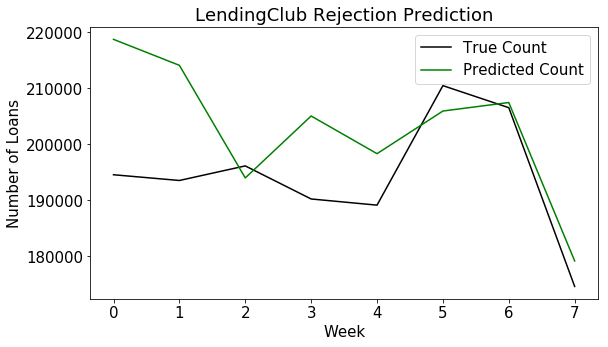

RMSE Train Score: 2736.76
MSE Train Score: 7489844.3148 

RMSE Test Score: 13033.1681 
MSE Test Score: 169863469.5315 

The model is off by 6.70%.  
The with the mean number of loan = 194412.50
and the root mean square error of 13033.17


In [529]:
import math
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(true_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Week')
plt.ylabel('Number of Loans')
plt.legend()
plt.show()

# make predictions
trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])

testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'RMSE Train Score: {trainScore1:.2f}')
trainScore2 = mean_squared_error(trainY[0], trainPredict[:, 0])
print('MSE Train Score: %.4f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('\nRMSE Test Score: %.4f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:, 0])
print('MSE Test Score: %.4f ' % (testScore4))

print('\nThe model is off by {:.2f}%.  \nThe with the mean number of loan = {:.2f}\nand the root mean square error of {:.2f}'
      .format(testScore3/actualMean*100, actualMean, testScore3))

_From the plot the model didn't do that well, it is overfitting.  It is predicting more rejections. The root mean square of the  actual and the predicted are not close at all._

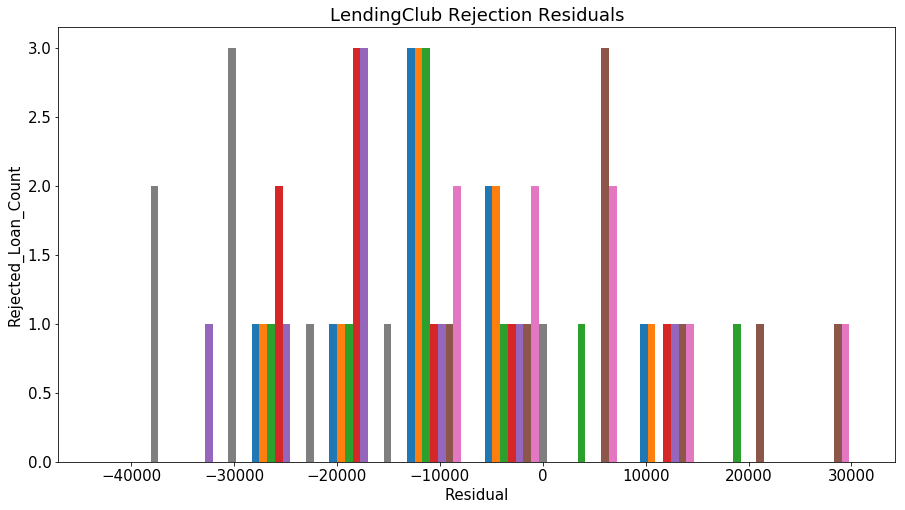

In [513]:
residual = testY - testPredict
plt.title('LendingClub Rejection Residuals')
plt.xlabel('Residual')
plt.ylabel('Rejected_Loan_Count')

plt.hist(residual,bins=10)
plt.show();

<Figure size 1440x360 with 0 Axes>

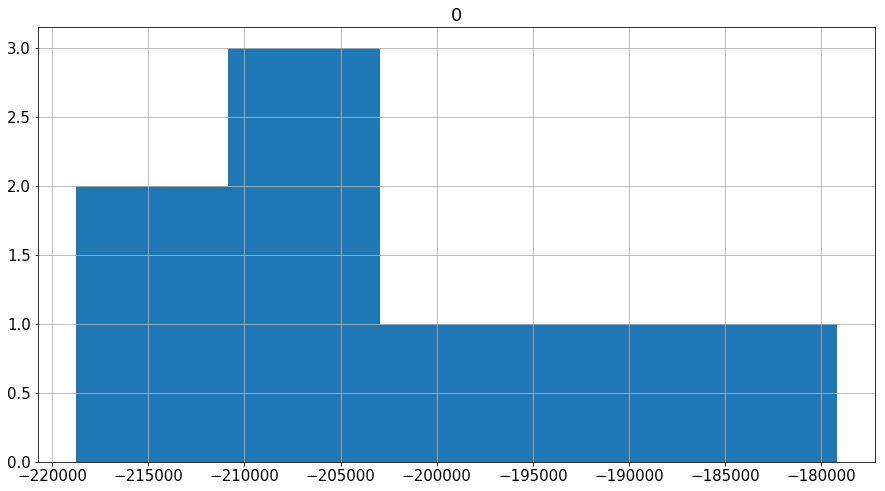

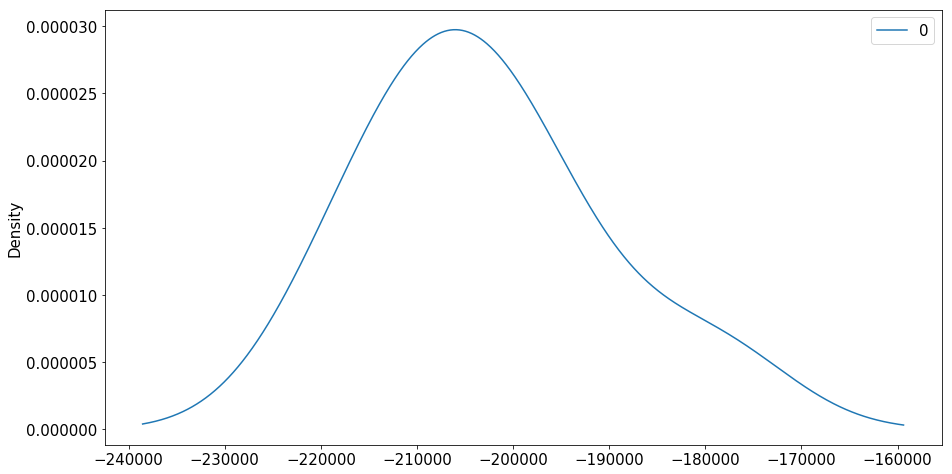

In [516]:
# calculate residuals
plt.figure(figsize=(20, 5))
from pandas import DataFrame
resids = [y_test[i]-testPredict[i] for i in range(len(testPredict))]
resids = DataFrame(resids)
resids=resids.dropna()
resids.hist(bins=5)
pyplot.show();

# density plot
resids.plot(kind='kde')
pyplot.show();

_We can see that the distribution does have a Gaussian look, that's right skewed, the mean is to the right of the median._

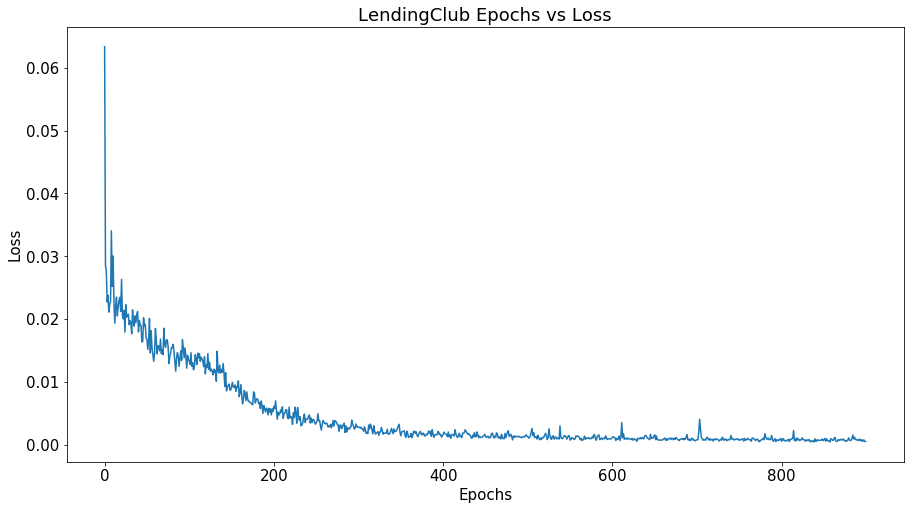

In [512]:
plt.title('LendingClub Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])

# Summary
SARIMA predicted 8 weeks and forecasted 12 weeks of loan rejection.  The best fit model has a `pdq=012` and `seasonality=1,1,1,13`. The errors were normally distributed and random.  The predicted model has a RMSE of 10,025 and a percent mean error of 5,484.  The model was off by 5.16%. 

LSTM model predicted better model than SARIMA model. The SARIMA RMSE = 1xxxxxx and the LSTM RMSE = which is a xxxx% difference.



This data can be used to forecast the number of loans that will get rejected weekly therefore LendingClub is able to set goals.  Investors are able to test their loans to see if in fact they would get rejected.  LendingClub would cut the time it takes to determine which loan is approved or rejected. The root mean square was 10025.50 and the average loan per week was 194412.50, this is about a 5% error.

LSTM model was buitl with 3 layers and 500 epochs.  The root mean square error is 3717


The LSTM model was a better model.  The SARIMA RMSE = 10,025.50 and the LSTM RMSE = which is a xx% difference.


#### References
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
https://people.duke.edu/~rnau/411arim.htm
https://blog.lipishala.com/2019/01/15/time-series-analysis-and-forecasting-with-lstm-using-keras/


In [498]:
pass

In [497]:
pass

## TensorFlow2 alpha

In [157]:
#!pip install -q tf-nightly-2.0-preview

  ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [158]:
# Clear any logs from previous runs
#!rm -rf ./Users/charla/*jupyter_notebook_projects/logs/

In [160]:
#log_dir="logs/fit/"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [474]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(100, return_sequences=True,
                               input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=1)

model_score = model.evaluate(X_test, y_test)

Epoch 1/50
101/101 [==============================] - 34s 336ms/sample - loss: 0.0520
Epoch 2/50
101/101 [==============================] - 5s 45ms/sample - loss: 0.0313
Epoch 3/50
101/101 [==============================] - 5s 50ms/sample - loss: 0.0265
Epoch 4/50
101/101 [==============================] - 6s 56ms/sample - loss: 0.0234
Epoch 5/50
101/101 [==============================] - 5s 50ms/sample - loss: 0.0277
Epoch 6/50
101/101 [==============================] - 5s 53ms/sample - loss: 0.0292
Epoch 7/50
101/101 [==============================] - 5s 50ms/sample - loss: 0.0242
Epoch 8/50
101/101 [==============================] - 5s 49ms/sample - loss: 0.0240
Epoch 9/50
101/101 [==============================] - 4s 44ms/sample - loss: 0.0251
Epoch 10/50
101/101 [==============================] - 5s 45ms/sample - loss: 0.0249
Epoch 11/50
101/101 [==============================] - 5s 48ms/sample - loss: 0.0220
Epoch 12/50
101/101 [==============================] - 4s 44ms/sample - 

In [475]:
print('Test loss:', model_score)

X_test = []
for i in range(8, 16):
    X_test.append(inputs[i-8:i, 0])
    # y_test.append(inputs[i, 0])#added this to see if i can do eval on ten
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_loans = model.predict(X_test)
predicted_loans = sc.inverse_transform(predicted_loans)

Test loss: 0.006708884611725807


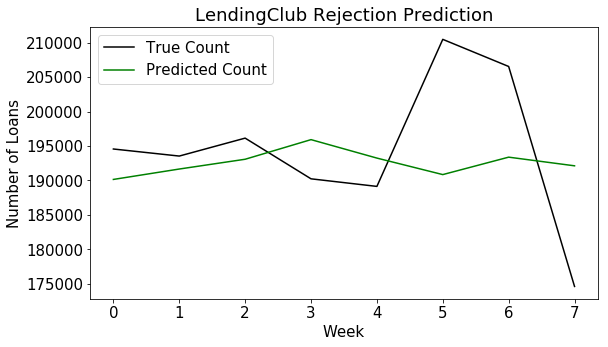

RMSE Train Score: 16212.35
MSE Train Score: 262840169.1675 

RMSE Test Score: 10880.2191 
MSE Test Score: 118379167.2675 


In [476]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(true_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Week')
plt.ylabel('Number of Loans')
plt.legend()
plt.show()


# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])

testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'RMSE Train Score: {trainScore1:.2f}')
trainScore2 = mean_squared_error(trainY[0], trainPredict[:, 0])
print('MSE Train Score: %.4f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('\nRMSE Test Score: %.4f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:, 0])
print('MSE Test Score: %.4f ' % (testScore4))

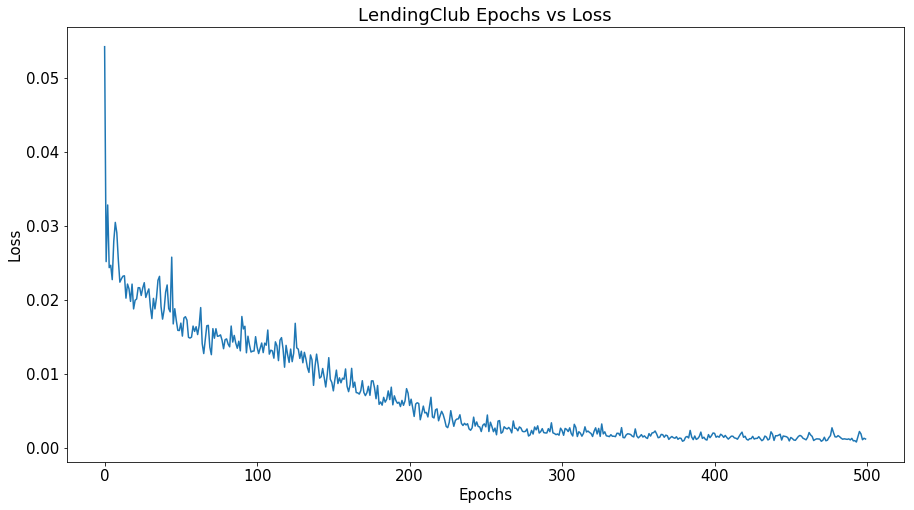

In [477]:
plt.title('LendingClub Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])

## TensorFlow 2.0 Beta

In [317]:
#!pip install tensorflow==2.0.0-beta1 

In [321]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.LSTM(10, return_sequences=True,
                               input_shape=(X_train.shape[1], 1)))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.LSTM(10, return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.LSTM(10, return_sequences=True))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.LSTM(10))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Dense(1))

model2.compile(optimizer='adam',
              loss='mean_squared_error')
model2.fit(X_train,
          y_train,
          epochs=50,
          batch_size=1)

model_score2 = model2.evaluate(X_test, y_test)

Epoch 1/50
101/101 [==============================] - 15s 144ms/sample - loss: 0.1018
Epoch 2/50
101/101 [==============================] - 4s 35ms/sample - loss: 0.0484
Epoch 3/50
101/101 [==============================] - 3s 33ms/sample - loss: 0.0329
Epoch 4/50
101/101 [==============================] - 3s 31ms/sample - loss: 0.0354
Epoch 5/50
101/101 [==============================] - 3s 30ms/sample - loss: 0.0338
Epoch 6/50
101/101 [==============================] - ETA: 0s - loss: 0.023 - 3s 29ms/sample - loss: 0.0247
Epoch 7/50
101/101 [==============================] - 3s 29ms/sample - loss: 0.0351
Epoch 8/50
101/101 [==============================] - 3s 31ms/sample - loss: 0.0344
Epoch 9/50
101/101 [==============================] - 3s 30ms/sample - loss: 0.0293
Epoch 10/50
101/101 [==============================] - 3s 32ms/sample - loss: 0.0276
Epoch 11/50
101/101 [==============================] - 3s 30ms/sample - loss: 0.0284
Epoch 12/50
101/101 [===========================

In [322]:
print('Test loss:', model_score2)
X_test = []
for i in range(8, 16):
    X_test.append(inputs[i-8:i, 0])
    # y_test.append(inputs[i, 0])#added this to see if i can do eval on ten
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_loans = model2.predict(X_test)
predicted_loans = sc.inverse_transform(predicted_loans)



Test loss: 0.007005891762673855


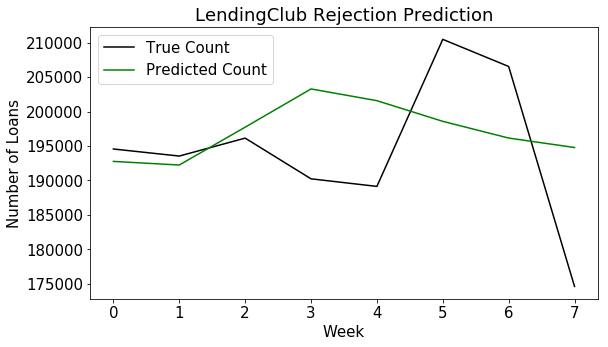

RMSE Train Score: 17220.35
MSE Train Score: 296540494.3404 

RMSE Test Score: 11118.4512 
MSE Test Score: 123619957.0610 


In [323]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(true_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Week')
plt.ylabel('Number of Loans')
plt.legend()
plt.show()


# make predictions
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])

testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'RMSE Train Score: {trainScore1:.2f}')
trainScore2 = mean_squared_error(trainY[0], trainPredict[:, 0])
print('MSE Train Score: %.4f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('\nRMSE Test Score: %.4f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:, 0])
print('MSE Test Score: %.4f ' % (testScore4))